In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [61]:
from termcolor import colored
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.special as sc
import seaborn as sns
import pickle

In [3]:
# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# bound_is = 750
experiment_length = 1800

In [46]:
CWD = os.getcwd()


In [5]:
main_folder = os.getcwd()
folder_experiments = 'results'

In [6]:
def check_float(potential_float):
    try:
        float(potential_float)
        return True

    except ValueError:
        return False

In [63]:
def to_pkl(data, data_name):
    # create a binary pickle file 
    f = open(data_name+'.pkl',"wb")

    # write the python object (dict) to pickle file
    pickle.dump(data,f)

    # close file
    f.close()
    
def from_pkl(data_name):
    file = open(data_name+'.pkl','rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

In [66]:
def sort_nested_dict(dictionary):
    temp = dict()
    for k1, val1 in sorted(dictionary.items()):
        temp[k1] = dict()
        for k2, val2 in sorted(val1.items()):
            temp[k1][k2] = dict()
            for k3, val3 in sorted(val2.items()):
                temp[k1][k2][k3] = val3
    return temp

In [7]:
def evaluate_convergence_time(times):
    conv_times = np.zeros(times.shape[0])
    #     print("Time shape", times.shape)
    for idx, elem in enumerate(times):
        if (elem[0] == -1):
            conv_times[idx] = elem[1]
        else:
            conv_times[idx] = elem.min()
    # c_time in ticks
    #     conv_time_batch = np.append(conv_time_batch, conv_times.max())
    return conv_times

In [8]:
def KM_estimator(data, censored):
    '''K-M estimator'''
    n_est = np.asarray(range(0, data.size))[::-1] + censored  # array from 29 to 0
    RT_sync = []
    for i in range(n_est.size):
        if len(RT_sync) == 0:
            RT_sync.append((n_est[i] - 1) / n_est[i])
        else:
            RT_sync.append(RT_sync[-1] * ((n_est[i] - 1) / n_est[i]))
    #     print(RT_sync)
    F = 1 - np.asarray(RT_sync).reshape(-1, 1)
    #     print(F)
    return F


def weib_cdf(x, alpha, gamma):
    return (1 - np.exp(-np.power(x / alpha, gamma)))

In [49]:
def weibull_plot(mean, std_dev, times_value, popt_weibull, F, figLabel, figName, conv_time_estimation):
    fig, ax = plt.subplots(figsize=(20, 8), dpi=160, facecolor='w', edgecolor='k')
    '''Textbox with mu and sigma'''
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mean,),
        r'$\sigma=%.2f$' % (std_dev,)))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    y_weib = weib_cdf(times_value, popt_weibull[0], popt_weibull[1])
    error_weib = np.power(y_weib - np.squeeze(F), 2)
    plt.plot(times_value, y_weib, 'r', linewidth=5, label="Weibull Distribution")
    plt.plot(times_value, F, 'b', linewidth=5, label="K-M stats")
    plt.legend(loc=4)
    plt.ylim(0, 1)
    if not conv_time_estimation:
        plt.xlim(0, times_value[-1])

    label = figLabel
    plt.title(label)
    plt.xlabel("Number of time steps")
    if conv_time_estimation:
        plt.ylabel("Synchronisation probability")
    else:
        plt.ylabel("Probability of passing over the target")
    
    plt.tight_layout()
    plt.savefig(os.path.join(CWD,'Plots',figName))
    plt.show()
    
#     plt.close(fig)


In [72]:
def plot_heatmap(dictionary, title, conv_time_estimation):
    for key, value in sorted(dictionary.items()):
        # print("Key value: ", key, value)
        fig = plt.figure(figsize=(12, 8), dpi=80)
        dataFrame = pd.DataFrame.from_dict(value)
        reversed_df = dataFrame.iloc[::-1]
        if conv_time_estimation:
            ax = sns.heatmap(reversed_df, annot=True, fmt=".2e", vmin=1500, vmax=3000, cmap="viridis")
        else:
            ax = sns.heatmap(reversed_df, annot=True, fmt=".2e", vmin=10000, vmax=40000, cmap="viridis")
        ax.set_title(title + ", num_robots:%s" % key)
        ax.set_ylabel("alpha")
        ax.set_xlabel("rho")
        #         plt.show()
        # Salva su file
        file_name = title + "_%s_robots.png" % (key)
#         plt.savefig(storage_dir + '/' + file_name)
        #     reversed_df.to_pickle(file_name[:-4] + ".pickle")
        plt.show()

### Main

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/20#robots_alpha#2.0_rho#0.0
num_robots 20, rho 0.0, alpha 2.0



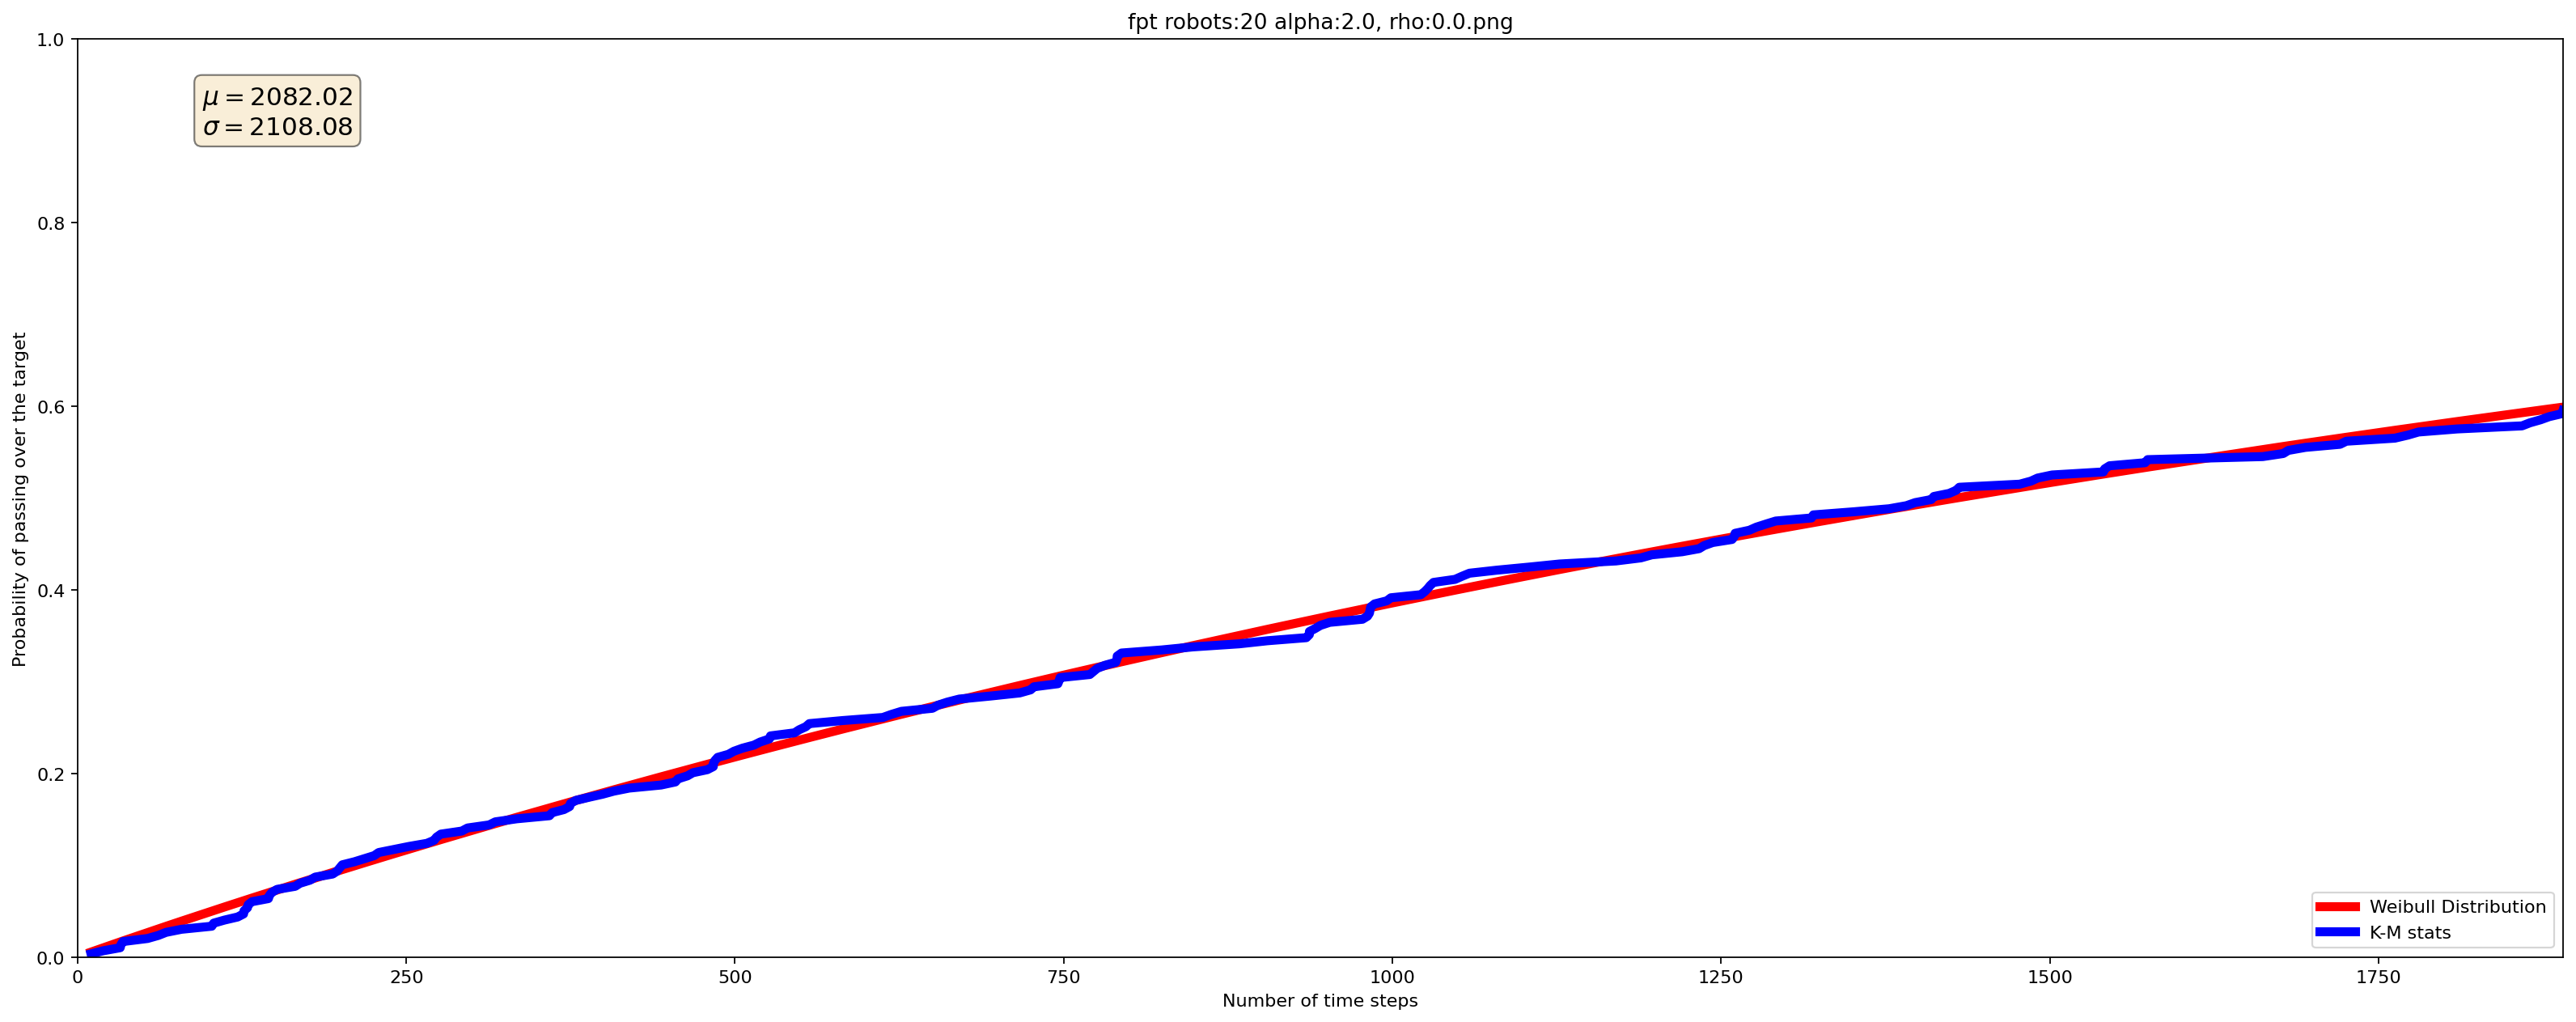

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/10#robots_alpha#2.0_rho#0.0
num_robots 10, rho 0.0, alpha 2.0



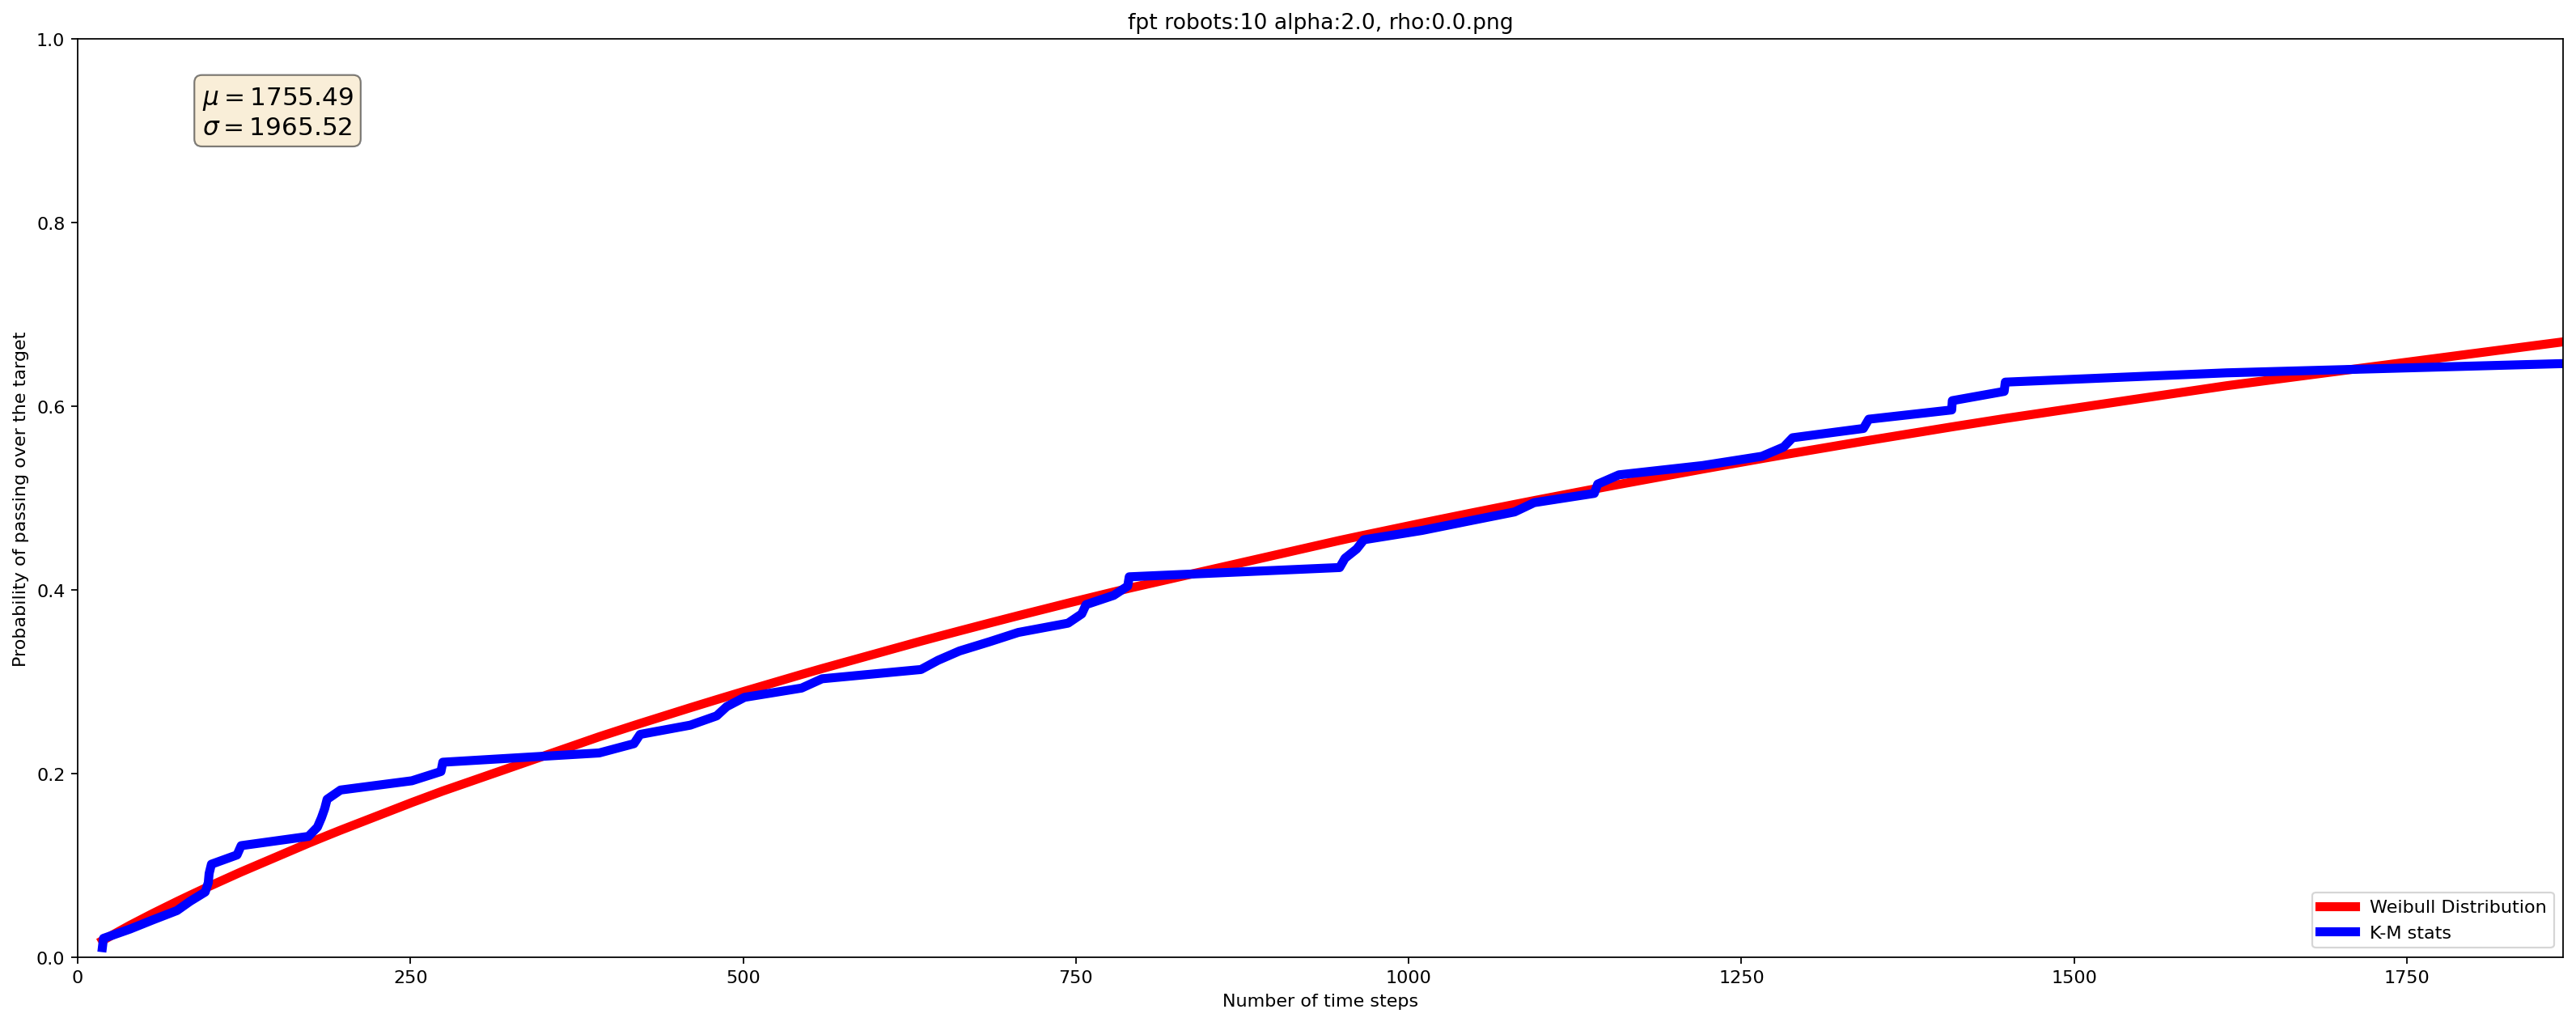

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/20#robots_alpha#2.0_rho#0.9
num_robots 20, rho 0.9, alpha 2.0



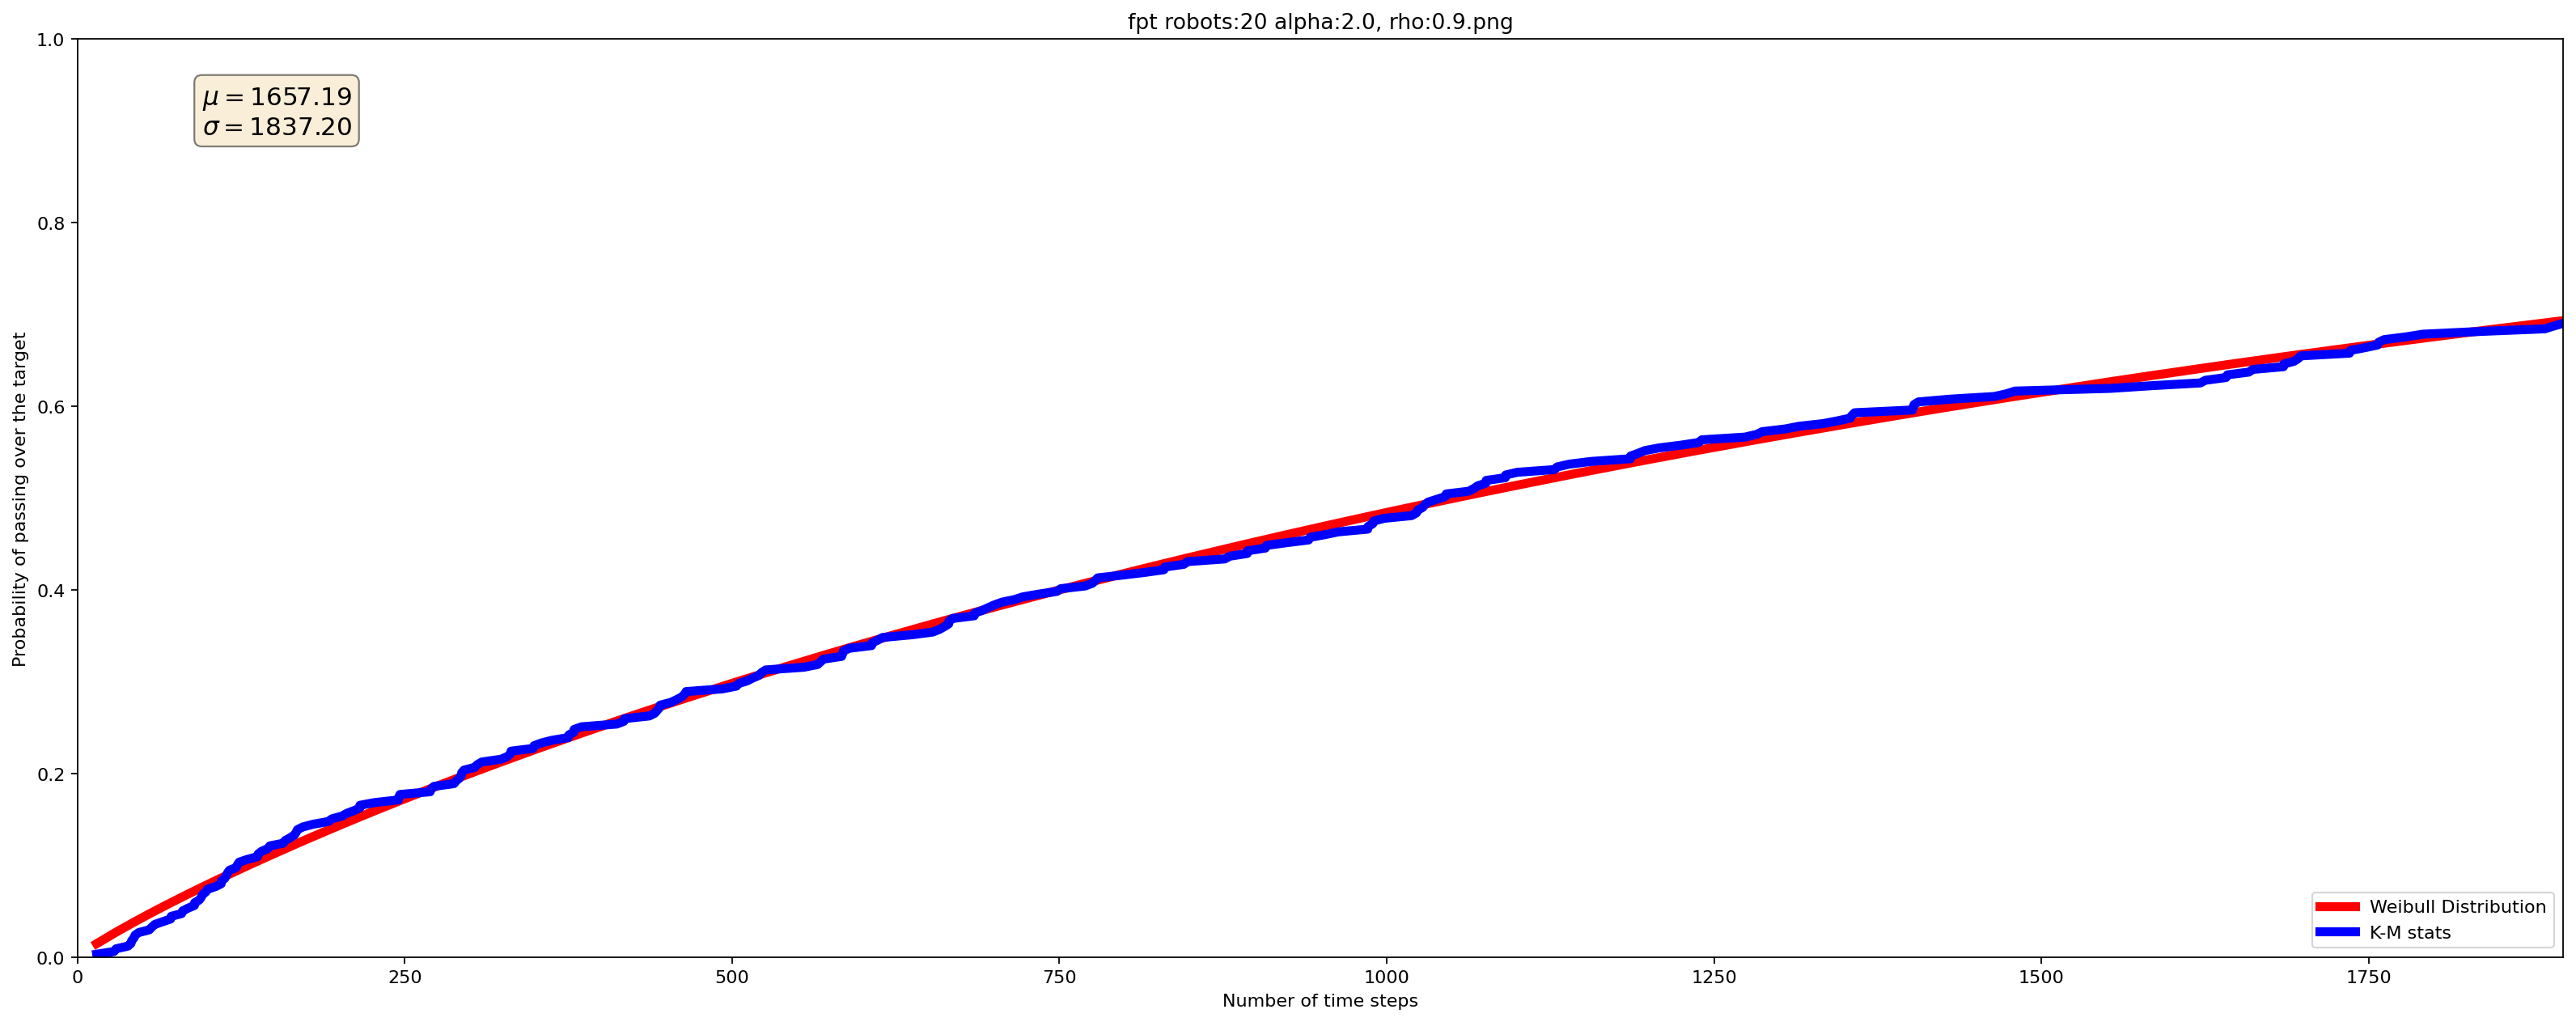

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/10#robots_alpha#2.0_rho#0.9
num_robots 10, rho 0.9, alpha 2.0



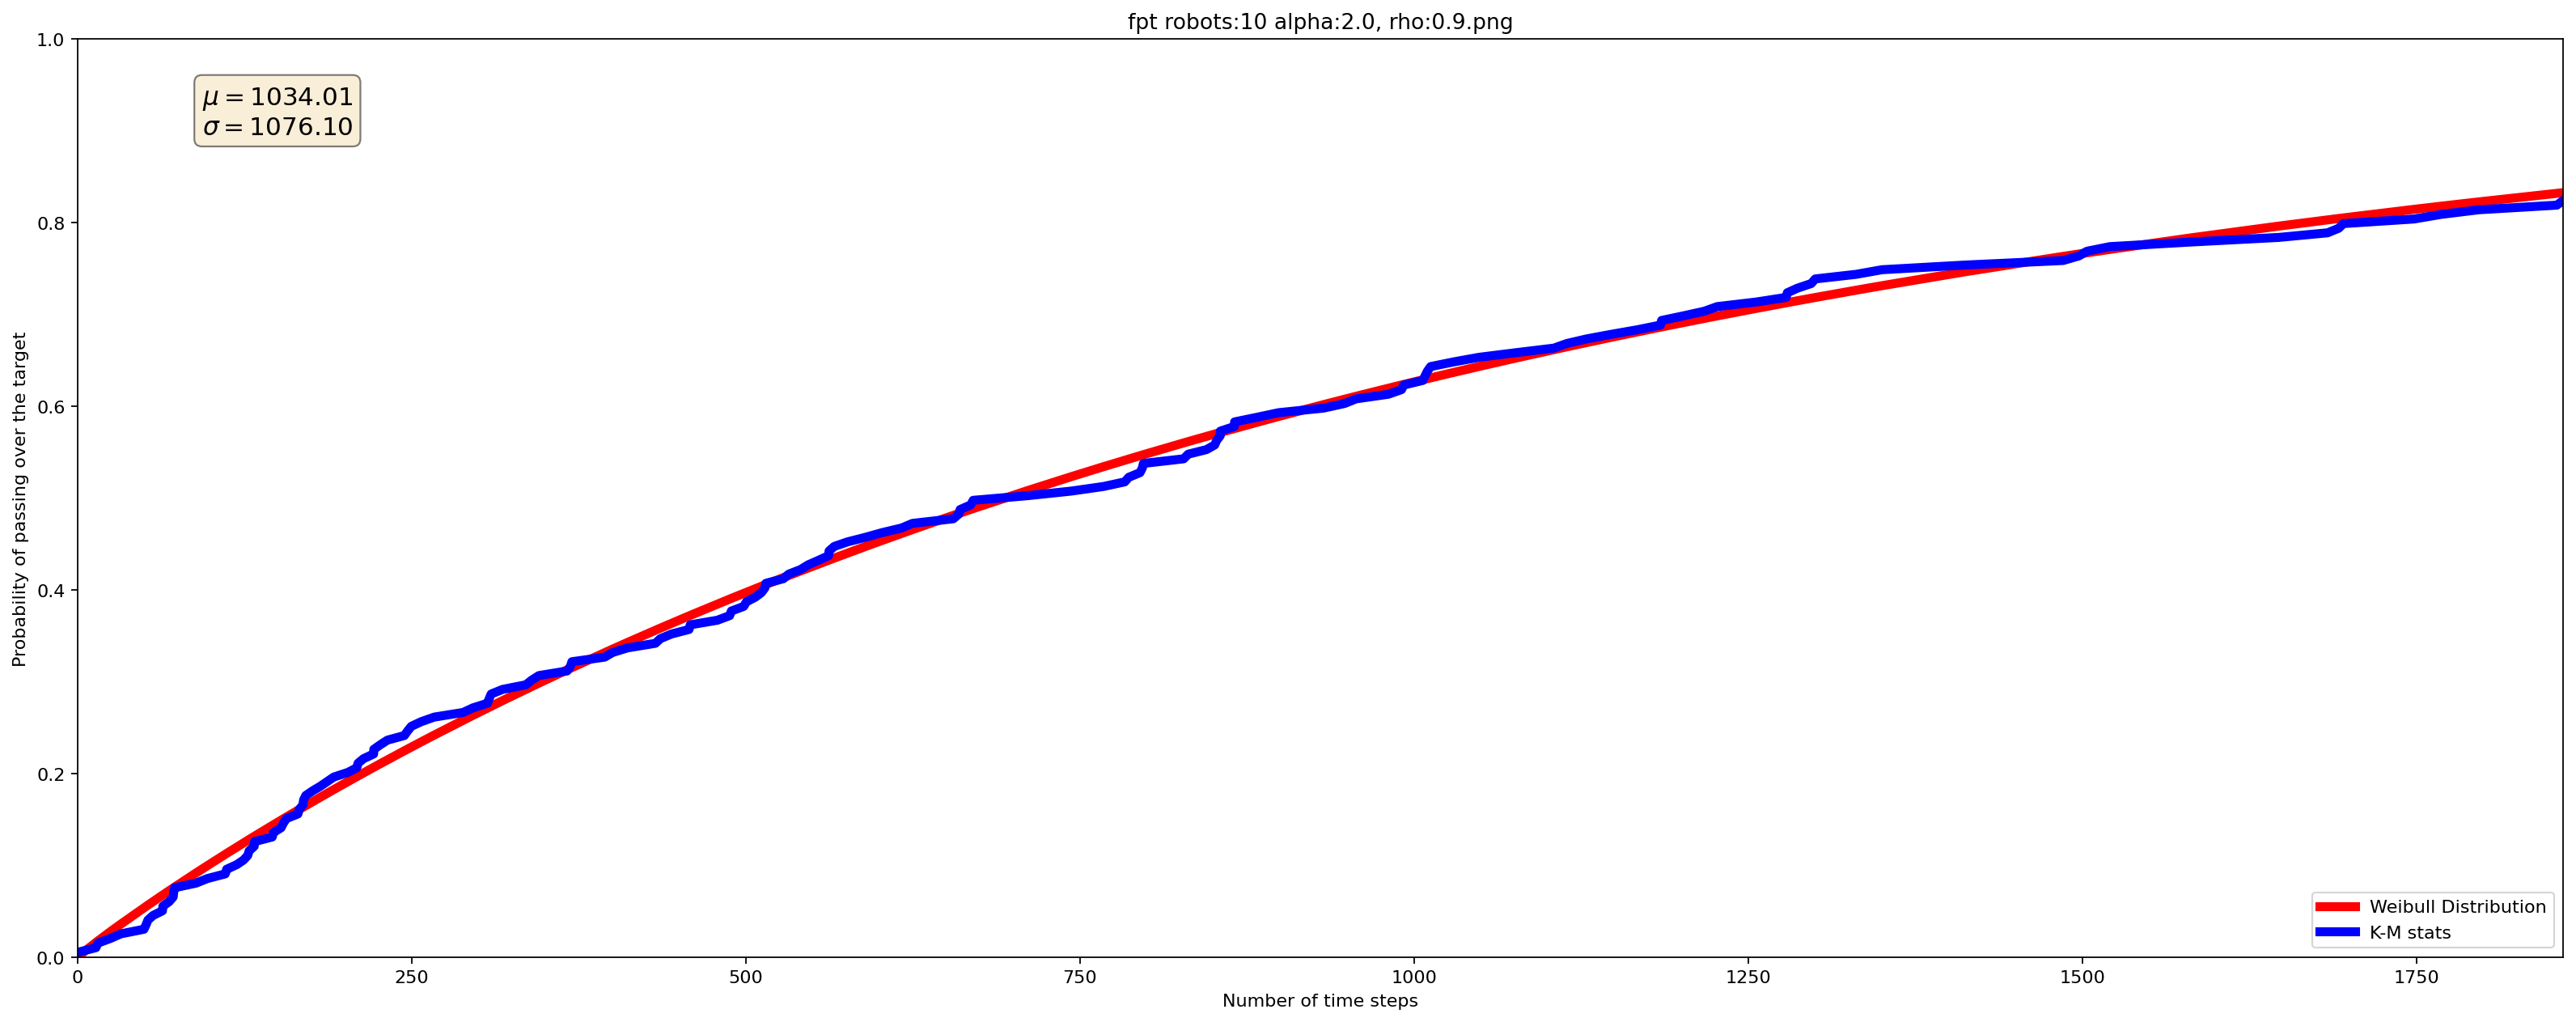

In [56]:
convergence_time_estimation = False   #if False ---> first passage time estimation

mean_fpt_dict = dict()
convergence_time_dict = dict()

for dirName, subdirList, fileList in os.walk(os.path.join(main_folder,'results')):
    
    num_robots = "-1"
    rho = -1.0
    alpha = -1.0
    elements = dirName.split("/")[-1].split("_")
#     print(colored("DirName:", 'blue'),dirName)
#     print(elements)
    for e in elements:
        if e.endswith("robots"):
            num_robots = e.split("#")[0]
            if num_robots not in mean_fpt_dict:
                mean_fpt_dict[num_robots] = dict()
                convergence_time_dict[num_robots] = dict()

        if (e.startswith("rho")):
            if check_float(e.split("#")[-1]): rho = float(e.split("#")[-1])
        if (e.startswith("alpha")):
            if check_float(e.split("#")[-1]): alpha = float(e.split("#")[-1])
    
    if num_robots == "-1" or rho == -1.0 or alpha == -1:
        continue
    
    print(colored("DirName:", 'blue'),dirName)
    print('num_robots {}, rho {}, alpha {}'.format(num_robots, rho, alpha), end='\n\n')
        
        
    differentSeeds_convergenceTime = np.array([])
    differentSeeds_firstPassageTime = np.array([])
    
    for filename in fileList:
        if filename.endswith('time_results.txt'):
#             print('\t', filename)
            if not os.path.getsize(os.path.join(dirName, filename)) > 0:
                print("Error, empty file at:" + os.path.join(fileList, filename))
                continue
            
            df_single = pd.read_csv(os.path.join(dirName, filename), sep="\t", header=None)
            rho_str = str(rho)
            alpha_str = str(alpha)
            #     print("rho", rho_str)
            #     print("alpha", alpha_str)
            if rho_str not in mean_fpt_dict[num_robots]:
                mean_fpt_dict[num_robots][rho_str] = dict()
                #         print(mean_fpt_dict)
                convergence_time_dict[num_robots][rho_str] = dict()
                
            np_times = df_single.to_numpy()[:,1:]
#             print(evaluate_convergence_time(np_times))
            differentSeeds_convergenceTime = np.row_stack([differentSeeds_convergenceTime, evaluate_convergence_time(np_times)]) if differentSeeds_convergenceTime.size else evaluate_convergence_time(np_times)
            
            differentSeeds_firstPassageTime = np.row_stack([differentSeeds_firstPassageTime, df_single.to_numpy()[:,1:2].reshape(-1)]) if differentSeeds_firstPassageTime.size else  df_single.to_numpy()[:,1:2].reshape(-1)
#             break

    '''**********************CONVERGENCE TIME**********************'''
    if convergence_time_estimation:
        convergenceTime = np.amax(differentSeeds_convergenceTime, axis=1)
        convergenceTime = convergenceTime[np.argsort(convergenceTime)]

        censored = convergenceTime.size - np.count_nonzero(convergenceTime)
#         print(convergenceTime)
        if censored:
            times_value = convergenceTime[censored:].reshape(-1)
        else:
            censored = 1
            times_value = convergenceTime.reshape(-1)

        F = KM_estimator(times_value, censored)

        # popt_weibull[0] is alpha
        # popt_weibull[1] is gamma
        bound_is = 500
        popt_weibull, _ = curve_fit(weib_cdf, xdata=times_value, ydata=np.squeeze(F), bounds=(0, [bound_is, 10]),
                                    method='trf')
        mean = sc.gamma(1 + (1. / popt_weibull[1])) * popt_weibull[0]
        #     print("mean",mean)
        std_dev = np.sqrt(popt_weibull[0] ** 2 * sc.gamma(1 + (2. / popt_weibull[1])) - mean ** 2)

        std_error = std_dev / np.sqrt(times_value.size)
        convergence_time_dict[num_robots][rho_str][alpha_str] = mean
        #     print(times_value.shape)

        figLabel = "Convergence Time robots:%s alpha:%s, rho:%s.png" % (num_robots, alpha_str, rho_str)
        figName = 'conv_time_robots_%s_alpha_%s_rho_%s.png' % (num_robots, alpha_str, rho_str)
        weibull_plot(mean, std_dev, times_value, popt_weibull, F, figLabel, figName, convergence_time_estimation) 
    
    else:
        differentSeeds_firstPassageTime[differentSeeds_firstPassageTime < 0] = 0
        censored = differentSeeds_firstPassageTime.size - np.count_nonzero(differentSeeds_firstPassageTime)
        # print(differentSeeds_firstPassageTime)
        differentSeeds_firstPassageTime = differentSeeds_firstPassageTime.reshape(-1)
        fpt = differentSeeds_firstPassageTime[np.argsort(differentSeeds_firstPassageTime)]
        times_value = fpt[censored:].reshape(-1)
        F = KM_estimator(times_value, censored)


        bound_is = 7500
        popt_weibull, _ = curve_fit(weib_cdf, xdata=times_value, ydata=np.squeeze(F), bounds=(0, [bound_is, 10]), method='trf')
        mean = sc.gamma(1 + (1. / popt_weibull[1])) * popt_weibull[0]
        mean_fpt_dict[num_robots][rho_str][alpha_str] = mean
        #     print("mean",mean)
        std_dev = np.sqrt(popt_weibull[0] ** 2 * sc.gamma(1 + (2. / popt_weibull[1])) - mean ** 2)

        std_error = std_dev / np.sqrt(times_value.size)

        #     print(times_value.shape)
        figLabel = "fpt robots:%s alpha:%s, rho:%s.png" % (num_robots, alpha_str, rho_str)
        figName = "fpt_robots_%s_alpha_%s_rho_%s.png" % (num_robots, alpha_str, rho_str)
        weibull_plot(mean, std_dev, times_value, popt_weibull, F, figLabel, figName, False)
        #             print(mean_fpt_dict, end="\n\n")
    
#     break

In [57]:
mean_fpt_dict

{'20': {'0.0': {'2.0': 2082.018831686925}, '0.9': {'2.0': 1657.1904847305634}},
 '10': {'0.0': {'2.0': 1755.4937834283867},
  '0.9': {'2.0': 1034.0059116758698}}}

In [55]:
mean_ct_dict = convergence_time_dict

In [58]:
mean_ct_dict

{'20': {'0.0': {'2.0': 183.54343995570045},
  '0.9': {'2.0': 125.99568845087241}},
 '10': {'0.0': {'2.0': 179.35946878346937}, '0.9': {'2.0': 177.549496340859}}}

In [62]:
to_pkl(mean_fpt_dict, 'mean_fpt_dict')
to_pkl(mean_ct_dict, 'mean_ct_dict')

In [69]:
ct_dict = sort_nested_dict(mean_ct_dict)
fpt_dict = sort_nested_dict(mean_fpt_dict)

In [70]:
ct_dict

{'10': {'0.0': {'2.0': 179.35946878346937}, '0.9': {'2.0': 177.549496340859}},
 '20': {'0.0': {'2.0': 183.54343995570045},
  '0.9': {'2.0': 125.99568845087241}}}

In [71]:
fpt_dict

{'10': {'0.0': {'2.0': 1755.4937834283867},
  '0.9': {'2.0': 1034.0059116758698}},
 '20': {'0.0': {'2.0': 2082.018831686925}, '0.9': {'2.0': 1657.1904847305634}}}

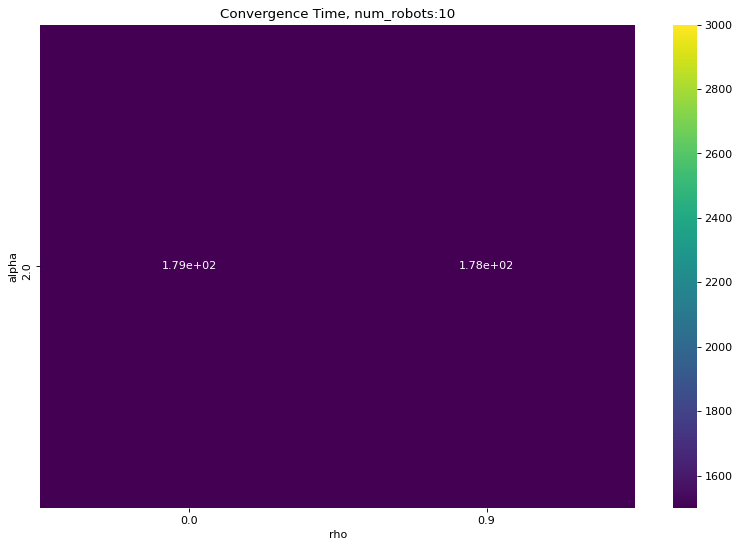

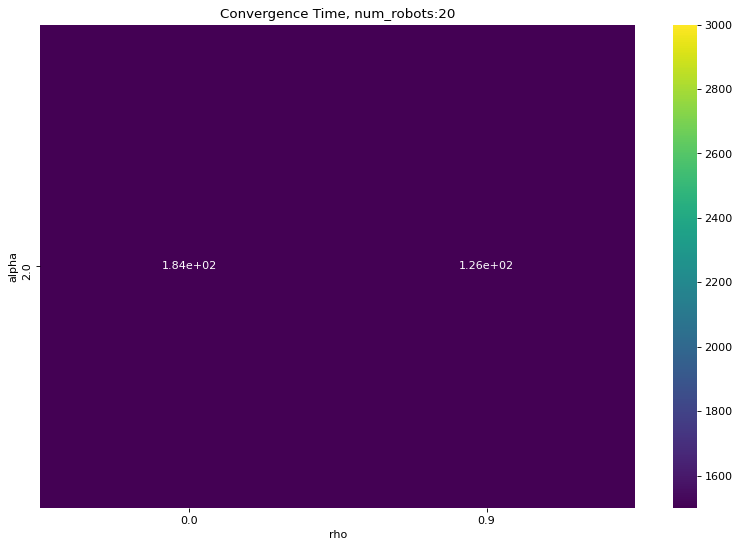

In [73]:
plot_heatmap(ct_dict, "Convergence Time", True)

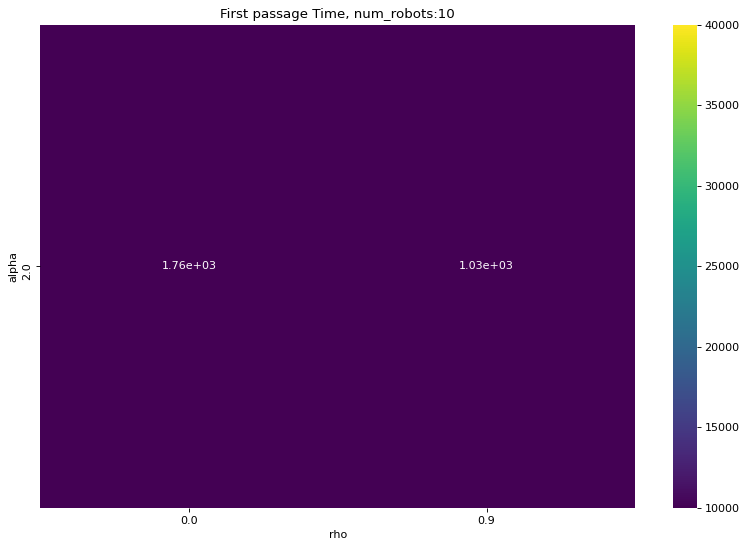

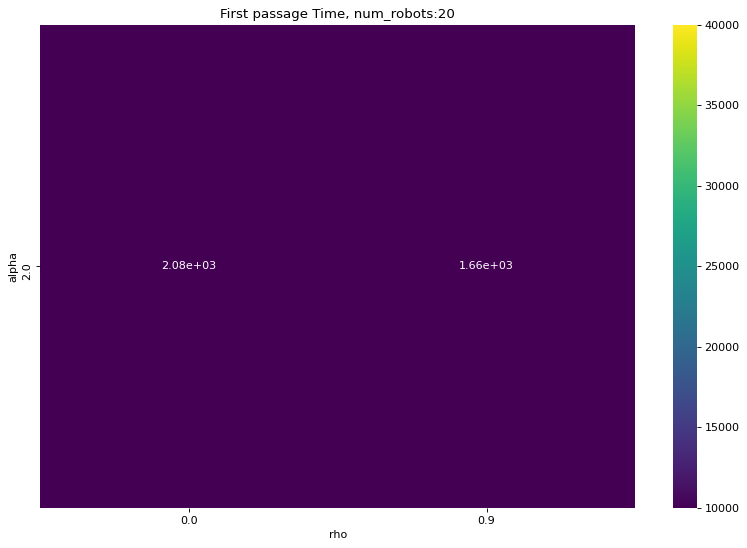

In [74]:
plot_heatmap(fpt_dict, "First passage Time", False)